In [50]:
CUDA_LAUNCH_BLOCKING="1"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import glob
import warnings
import cv2
import numpy as np
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2


warnings.filterwarnings('ignore')
import seaborn as sns
import torchvision.models as models
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
# device = torch.device('cpu')

In [5]:
device

device(type='cuda')

In [6]:
import pandas as pd

In [7]:
import glob
import random

all_path = glob.glob('/kaggle/input/breast-cancer-dataset/BreaKHis_Total_dataset/*/*')
random.shuffle(all_path)
# train_paths = all_path[0:int(.7*len(all_path))]
# val_paths = all_path[int(.7*len(all_path))-1:-1]
# test_paths = all_path[int()]

# train_df = pd.DataFrame([[0 if x.split('/')[5]=='benign' else 1,x]  for x in train_paths],columns=['label','path'])
# val_df = pd.DataFrame([[0 if x.split('/')[5]=='benign' else 1,x]  for x in val_paths],columns=['label','path'])

In [9]:
df = pd.DataFrame([[0 if x.split('/')[5]=='benign' else 1,x]  for x in all_path],columns=['label','path'])

In [10]:
df

,label,path
0,1,/kaggle/input/breast-cancer-dataset/BreaKHis_T...
1,0,/kaggle/input/breast-cancer-dataset/BreaKHis_T...
2,0,/kaggle/input/breast-cancer-dataset/BreaKHis_T...
3,1,/kaggle/input/breast-cancer-dataset/BreaKHis_T...
4,0,/kaggle/input/breast-cancer-dataset/BreaKHis_T...
...,...,...
7778,0,/kaggle/input/breast-cancer-dataset/BreaKHis_T...
7779,1,/kaggle/input/breast-cancer-dataset/BreaKHis_T...
7780,0,/kaggle/input/breast-cancer-dataset/BreaKHis_T...
7781,1,/kaggle/input/breast-cancer-dataset/BreaKHis_T...


In [15]:
from tqdm.notebook import tqdm

In [32]:
for i in tqdm(range(len(df))):
    try:
        cv2.imread(df['path'][i])
        
    except:
        print(i)

  0%|          | 0/7783 [00:00<?, ?it/s]

In [34]:
test_df = df.groupby('label').sample(n=780).reset_index(drop=True)
temp_df = df.drop(test_df.index).reset_index(drop=True)
temp_df.head()

,label,path
0,0,/kaggle/input/breast-cancer-dataset/BreaKHis_T...
1,0,/kaggle/input/breast-cancer-dataset/BreaKHis_T...
2,1,/kaggle/input/breast-cancer-dataset/BreaKHis_T...
3,1,/kaggle/input/breast-cancer-dataset/BreaKHis_T...
4,1,/kaggle/input/breast-cancer-dataset/BreaKHis_T...


In [35]:
temp_df['label'].value_counts()

1    4259
0    1964
Name: label, dtype: int64

In [39]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(temp_df,test_size = .25)

In [43]:
valid_df['label'].value_counts()
train_df['label'].value_counts()

1    3180
0    1487
Name: label, dtype: int64

In [45]:
print('Training set')
print(train_df.label.value_counts())

print('\nValidation set')
print(valid_df.label.value_counts())

print('\nTest set')
print(test_df.label.value_counts())

Training set
1    3180
0    1487
Name: label, dtype: int64

Validation set
1    1079
0     477
Name: label, dtype: int64

Test set
0    780
1    780
Name: label, dtype: int64


In [46]:
train_df.reset_index(drop=True,inplace=True)
valid_df.reset_index(drop=True,inplace=True)

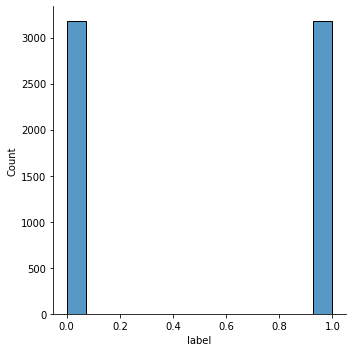

In [51]:
max_count = np.max(train_df.label.value_counts())
min_count = np.min(train_df.label.value_counts())
train_df = train_df.groupby('label').sample(n=max_count, replace=True)
train_df = train_df.reset_index(drop=True)
train_df.label.value_counts()

ax = sns.displot(data=train_df, x='label')

In [44]:
class Config:
    img_size=224
    batch_size = 16
    num_epochs = 20
    num_classes = 2
    learning_rate = .001

In [52]:
class transforms:
    train_transforms = Compose([
        Resize(Config.img_size,Config.img_size),
        Transpose(p=.3),
        HorizontalFlip(p=.5),
        VerticalFlip(p=.4),
        ToTensorV2(p=1.0),],p=1)
    
    valid_transforms = Compose([
        Resize(Config.img_size,Config.img_size),       
        ToTensorV2(p=1.0),],p=1)
    
    test_transforms = Compose([
    Resize(Config.img_size,Config.img_size),       
    ToTensorV2(p=1.0),],p=1)

In [53]:
class CancerDataset(Dataset):
    def __init__(self,df,transform=None):
        super().__init__()
        self.df=df
        self.transform=transform
        self.paths=self.df['path']
        self.labels=self.df['label']
        
    def __getitem__(self,idx):
        path=self.paths[idx]
        label= torch.tensor([self.labels[idx]]).float()
        img=cv2.imread(path)

        im_max = np.max(img)
        im_min = np.min(img)
        img = (img-im_min)/(im_max-im_min)
        
        if self.transform:
            img = self.transform(image=img)['image']
        
        return [img.float(),label]
    def __len__(self):
        return len(self.df)

In [54]:
train_dataset=CancerDataset(train_df,transform=transforms.train_transforms)
val_dataset=CancerDataset(valid_df,transform=transforms.valid_transforms)
test_dataset = CancerDataset(test_df,transform=transforms.test_transforms)

In [1]:
plt.imshow(train_dataset[100][0].permute(2,1,0))

NameError: name 'plt' is not defined

In [56]:
print(train_dataset[100][0])

tensor([[[0.5294, 0.5025, 0.4903,  ..., 0.4612, 0.3461, 0.3907],
         [0.5511, 0.4938, 0.5129,  ..., 0.3226, 0.3619, 0.3630],
         [0.6087, 0.5644, 0.4506,  ..., 0.3699, 0.3875, 0.3515],
         ...,
         [0.4450, 0.4655, 0.4360,  ..., 0.6584, 0.6606, 0.6380],
         [0.4947, 0.4176, 0.4582,  ..., 0.6548, 0.6457, 0.6326],
         [0.3995, 0.3860, 0.3797,  ..., 0.6654, 0.6493, 0.6326]],

        [[0.3898, 0.3629, 0.3421,  ..., 0.3002, 0.1851, 0.2264],
         [0.3918, 0.3227, 0.3478,  ..., 0.1352, 0.1810, 0.1700],
         [0.4353, 0.3980, 0.3239,  ..., 0.1775, 0.1964, 0.1618],
         ...,
         [0.2452, 0.2505, 0.2820,  ..., 0.8084, 0.7997, 0.7888],
         [0.2976, 0.2349, 0.2921,  ..., 0.8241, 0.8111, 0.7793],
         [0.2231, 0.2250, 0.2300,  ..., 0.7913, 0.7676, 0.7430]],

        [[0.4555, 0.4286, 0.4078,  ..., 0.3367, 0.2216, 0.2624],
         [0.4753, 0.3943, 0.4075,  ..., 0.1763, 0.2102, 0.2095],
         [0.5037, 0.4651, 0.4000,  ..., 0.2392, 0.2441, 0.

In [57]:
train_loader = DataLoader(train_dataset,batch_size=Config.batch_size,shuffle=True,num_workers=2)
val_loader = DataLoader(val_dataset,batch_size=Config.batch_size,shuffle=False,num_workers=2)
test_loader = DataLoader(test_dataset,batch_size=Config.batch_size,shuffle=False,num_workers=2)

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(40,40))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [14]:
# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [15]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
#     since = time.time()
    
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0
#             running_auc=0.0

#             # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)

#                     loss = criterion(outputs, labels)

                    
#                     #auc=roc_auc_score(outputs.cpu().max(1)[1],labels)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 #running_auc +=auc.item() * inputs.size(0)
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)
#             if phase == 'train':
#                 scheduler.step()
#             #epoch_auc = running_auc / dataset_sizes[phase]
#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             #AUC: {:.4f}, epoch_auc
#             print('{} Loss: {:.4f} Acc: {:.4f} '.format(        
#                 phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

In [58]:
class Inception_block(nn.Module):
    def __init__(self,in_channels,out_1x1,redu_3x3,out_3x3,redu_5x5,out_5x5,out_1x1pool):
        super(Inception_block,self).__init__()
        self.branch_1 = conv_block(in_channels,out_1x1,kernel_size=1)
        self.branch_2 = nn.Sequential(
            conv_block(in_channels,redu_3x3,kernel_size=1),
            conv_block(redu_3x3,out_3x3,kernel_size=3,padding=1)
        )

        self.branch_3 = nn.Sequential(
            conv_block(in_channels,redu_5x5,kernel_size=1),
            conv_block(redu_5x5,out_5x5,kernel_size=5,padding=2)
        )
        
        self.branch_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
            conv_block(in_channels,out_1x1pool,kernel_size=1)
        )
        
        
    def forward(self,x):
#         print(self.branch_1(x).shape)
#         print(self.branch_2(x).shape)
#         print(self.branch_3(x).shape)
#         print(self.branch_4(x).shape)
        return torch.cat([self.branch_1(x),self.branch_2(x),self.branch_3(x),self.branch_4(x)],1)

In [59]:
class conv_block(nn.Module):
    def __init__(self,in_channels,out_channels,**kwargs):
        super(conv_block,self).__init__()
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        
    def forward(self,x):
#         return self.relu(self.bn(self.conv(x)))
          return self.relu((self.conv(x)))

In [60]:
class VGGIN(nn.Module):
    def __init__(self):
        super(VGGIN,self).__init__()
        self.model = models.vgg16(pretrained=True)
        self.model = self.model.features[0:25]
        
        for params in self.model.parameters():
            params.requires_grad = False
            
        self.high_level = Inception_block(512,64,96,128,16,32,512)
        self.model[24] = self.high_level
        self.classifier = nn.Sequential(
                      nn.BatchNorm2d(736),
                      nn.Flatten(1,-1),
                      nn.Dropout(p=0.4),
                      nn.Linear(14*14*736, 2),
                        )

        
    def forward(self,x):
        return self.classifier(self.model(x))

In [62]:
Model = VGGIN().to(device)

ex = iter(train_loader)
image,label = next(ex)
image = image.to(device).float()
image.shape
outputs = Model(image)
outputs.shape, outputs

(torch.Size([16, 2]),
 tensor([[ 7.4791e-02,  9.8391e-01],
         [ 1.2942e+00,  5.4927e-01],
         [-2.6765e-01,  2.0161e-01],
         [ 7.7284e-01, -2.0749e-01],
         [-5.4408e-01, -2.4294e+00],
         [ 6.3915e-01,  9.4901e-01],
         [ 2.0899e-01, -5.7642e-01],
         [-2.5335e-01,  4.9927e-01],
         [ 9.0359e-02, -2.9039e-01],
         [ 5.8603e-02, -4.6483e-01],
         [-1.8303e-01,  3.8604e-01],
         [ 8.4773e-01,  5.1319e-01],
         [-1.8260e-01,  6.8673e-01],
         [ 4.8444e-01,  6.6659e-01],
         [ 4.4245e-01,  1.4215e-03],
         [ 3.2965e-01, -5.9520e-01]], device='cuda:0', grad_fn=<AddmmBackward0>))

In [63]:
# class_weights = torch.tensor([1.0, 2.0])
# weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(Model.parameters(),lr = Config.learning_rate,weight_decay=1e-5)

In [64]:
train_count = len(train_loader.dataset)
train_count
n_total_steps = len(train_loader)

In [65]:
training_loss = []
validation_loss = []

In [66]:
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")

In [68]:
#training
best_acc = 0

n_total_steps = len(train_loader)
for epoch in tqdm(range(Config.num_epochs)):
    
    n_correct = 0
    n_samples = 0
    avg_loss = 0
    avg_val_loss =0
    
    
    Model.train()
    for i, (images,labels) in tqdm(enumerate(train_loader)):
        

        images = images.to(device).float()
        labels = labels.to(device).long()
        

        #forward pass
        outputs = Model(images)
        loss = criterion(outputs,labels.squeeze())

        
        #back pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()


        if (i+1)%50 == 0:

                print(f'epoch {epoch+1}/{Config.num_epochs} , step {i+1}/{n_total_steps}, loss = {avg_loss/(i+1):.4f}')
#     scheduler.step() 
    training_loss.append(avg_loss/n_total_steps)

    
    Model.eval()

    with torch.no_grad():
        for batch_idx,(images,labels) in tqdm(enumerate(val_loader)):
            
            images = images.to(device).float()
            labels = labels.to(device).long()

            #forward pass
            outputs = Model(images)

            val_loss = criterion(outputs,labels.squeeze())
            avg_val_loss += val_loss.item()

            if (batch_idx+1)%10 == 0:
                print(f'Validation loss is {avg_val_loss/(batch_idx+1)}')
                if(avg_val_loss==0):
                    print('Kahini ache eikhane')
                    print(outputs,labels.squeeze())
                        
            indices = torch.argmax(torch.nn.functional.softmax(outputs,-1),1)
            
            n_correct += (indices==labels.squeeze()).sum().item()
            n_samples += labels.size(0)
            
        validation_loss.append(avg_val_loss/(batch_idx+1))
        acc = 100*n_correct/n_samples
        if acc>best_acc:
            best_acc = acc
            torch.save(Model.state_dict(), 'best_Model.pt')
#         print(f'Validation loss is {val_loss}')
        print(f'Accuracy of the validation data is {acc}%')

  0%|          | 0/20 [00:10<?, ?it/s]

0it [00:00, ?it/s]

epoch 1/20 , step 50/398, loss = 3.9176
epoch 1/20 , step 100/398, loss = 3.4012
epoch 1/20 , step 150/398, loss = 3.2585
epoch 1/20 , step 200/398, loss = 3.4821
epoch 1/20 , step 250/398, loss = 3.4217
epoch 1/20 , step 300/398, loss = 3.4443
epoch 1/20 , step 350/398, loss = 3.4551


0it [00:00, ?it/s]

Validation loss is 2.1953623396399053
Validation loss is 2.6262813291074054
Validation loss is 3.346691589959543
Validation loss is 3.0398862297893174
Validation loss is 3.0709351083088405
Validation loss is 3.179737563633866
Validation loss is 3.2959126606191456
Validation loss is 3.2391751425928974
Validation loss is 3.1926662036637117
Accuracy of the validation data is 85.47557840616966%


0it [00:00, ?it/s]

epoch 2/20 , step 50/398, loss = 2.9390
epoch 2/20 , step 100/398, loss = 2.7035
epoch 2/20 , step 150/398, loss = 2.7291
epoch 2/20 , step 200/398, loss = 2.7498
epoch 2/20 , step 250/398, loss = 2.7374
epoch 2/20 , step 300/398, loss = 2.7527
epoch 2/20 , step 350/398, loss = 2.7297


0it [00:00, ?it/s]

Validation loss is 4.232047236151994
Validation loss is 4.323318590479903
Validation loss is 4.428906755816812
Validation loss is 4.006298665814074
Validation loss is 4.42878680655358
Validation loss is 4.275666056026997
Validation loss is 4.2259783863595395
Validation loss is 4.248288495615111
Validation loss is 4.170072918434926
Accuracy of the validation data is 85.15424164524421%


0it [00:00, ?it/s]

epoch 3/20 , step 50/398, loss = 3.0647
epoch 3/20 , step 100/398, loss = 2.6132
epoch 3/20 , step 150/398, loss = 2.7343
epoch 3/20 , step 200/398, loss = 2.7004
epoch 3/20 , step 250/398, loss = 2.5775
epoch 3/20 , step 300/398, loss = 2.5841
epoch 3/20 , step 350/398, loss = 2.5401


0it [00:00, ?it/s]

Validation loss is 5.546806005219696
Validation loss is 4.691829590787529
Validation loss is 4.645457798931187
Validation loss is 4.743266885499049
Validation loss is 4.570865630324594
Validation loss is 4.3567264167930615
Validation loss is 4.388599813598898
Validation loss is 4.386557498366826
Validation loss is 4.251590714998769
Accuracy of the validation data is 83.74035989717224%


0it [00:00, ?it/s]

epoch 4/20 , step 50/398, loss = 1.7760
epoch 4/20 , step 100/398, loss = 1.8101
epoch 4/20 , step 150/398, loss = 1.8413
epoch 4/20 , step 200/398, loss = 1.9045
epoch 4/20 , step 250/398, loss = 1.9648
epoch 4/20 , step 300/398, loss = 1.9647
epoch 4/20 , step 350/398, loss = 1.9824


0it [00:00, ?it/s]

Validation loss is 4.023514649271965
Validation loss is 3.5474558628484374
Validation loss is 3.361361036283779
Validation loss is 2.960937146531711
Validation loss is 2.793272417637859
Validation loss is 2.739358666417627
Validation loss is 2.710034650121351
Validation loss is 2.512062458801259
Validation loss is 2.4454752307924044
Accuracy of the validation data is 89.78149100257069%


0it [00:00, ?it/s]

epoch 5/20 , step 50/398, loss = 1.0572
epoch 5/20 , step 100/398, loss = 1.5108
epoch 5/20 , step 150/398, loss = 1.5754
epoch 5/20 , step 200/398, loss = 1.6225
epoch 5/20 , step 250/398, loss = 1.7480
epoch 5/20 , step 300/398, loss = 1.7242
epoch 5/20 , step 350/398, loss = 1.6773


0it [00:00, ?it/s]

Validation loss is 3.9575579702854156
Validation loss is 3.379823438823223
Validation loss is 3.5198745721082862
Validation loss is 3.3678311099112763
Validation loss is 3.666409823516442
Validation loss is 3.3637927605467364
Validation loss is 3.3294124308447604
Validation loss is 3.352977076080242
Validation loss is 3.226481717731642
Accuracy of the validation data is 85.79691516709512%


0it [00:00, ?it/s]

epoch 6/20 , step 50/398, loss = 1.9825
epoch 6/20 , step 100/398, loss = 1.6739
epoch 6/20 , step 150/398, loss = 1.6242
epoch 6/20 , step 200/398, loss = 1.5801
epoch 6/20 , step 250/398, loss = 1.4639
epoch 6/20 , step 300/398, loss = 1.5446
epoch 6/20 , step 350/398, loss = 1.5127


0it [00:00, ?it/s]

Validation loss is 4.179558634757996
Validation loss is 3.3536543058755344
Validation loss is 3.573469859365529
Validation loss is 3.1996427786532875
Validation loss is 3.050764092169411
Validation loss is 2.9737151601349314
Validation loss is 2.923580193333115
Validation loss is 2.7866207187455942
Validation loss is 2.6587736008613585
Accuracy of the validation data is 89.33161953727506%


0it [00:00, ?it/s]

epoch 7/20 , step 50/398, loss = 1.0960
epoch 7/20 , step 100/398, loss = 1.1529
epoch 7/20 , step 150/398, loss = 1.2808
epoch 7/20 , step 200/398, loss = 1.3553
epoch 7/20 , step 250/398, loss = 1.3585
epoch 7/20 , step 300/398, loss = 1.3126
epoch 7/20 , step 350/398, loss = 1.2918


0it [00:00, ?it/s]

Validation loss is 3.2481784224510193
Validation loss is 2.886502329260111
Validation loss is 3.0900248669087556
Validation loss is 2.9240431549492962
Validation loss is 2.839226784594336
Validation loss is 2.716663440347929
Validation loss is 2.630208090579643
Validation loss is 2.5256996333308277
Validation loss is 2.367159712092143
Accuracy of the validation data is 90.74550128534705%


0it [00:00, ?it/s]

epoch 8/20 , step 50/398, loss = 1.3732
epoch 8/20 , step 100/398, loss = 1.1331
epoch 8/20 , step 150/398, loss = 1.0253
epoch 8/20 , step 200/398, loss = 1.0893
epoch 8/20 , step 250/398, loss = 1.0913
epoch 8/20 , step 300/398, loss = 1.0923
epoch 8/20 , step 350/398, loss = 1.0783


0it [00:00, ?it/s]

Validation loss is 2.5345592620782553
Validation loss is 2.299191214534221
Validation loss is 2.890628466021732
Validation loss is 2.805950555959132
Validation loss is 2.7387834301660066
Validation loss is 2.653202889865435
Validation loss is 2.6350297676714804
Validation loss is 2.4685591174332586
Validation loss is 2.3163829044128734
Accuracy of the validation data is 91.96658097686375%


0it [00:00, ?it/s]

epoch 9/20 , step 50/398, loss = 0.8338
epoch 9/20 , step 100/398, loss = 1.1376
epoch 9/20 , step 150/398, loss = 1.2619
epoch 9/20 , step 200/398, loss = 1.3761
epoch 9/20 , step 250/398, loss = 1.2665
epoch 9/20 , step 300/398, loss = 1.2017
epoch 9/20 , step 350/398, loss = 1.1631


0it [00:00, ?it/s]

Validation loss is 2.8044953439384672
Validation loss is 2.099815867252617
Validation loss is 2.6047395873615917
Validation loss is 2.3274085536850935
Validation loss is 2.654374579016645
Validation loss is 2.5763179596300585
Validation loss is 2.6784271418067527
Validation loss is 2.583704836115035
Validation loss is 2.393321105978666
Accuracy of the validation data is 91.58097686375321%


0it [00:00, ?it/s]

epoch 10/20 , step 50/398, loss = 0.9537
epoch 10/20 , step 100/398, loss = 1.0750
epoch 10/20 , step 150/398, loss = 1.0453
epoch 10/20 , step 200/398, loss = 1.0415
epoch 10/20 , step 250/398, loss = 1.0002
epoch 10/20 , step 300/398, loss = 1.0212
epoch 10/20 , step 350/398, loss = 1.0607


0it [00:00, ?it/s]

Validation loss is 5.92361410856247
Validation loss is 5.399035948514938
Validation loss is 4.9282007890714645
Validation loss is 4.4214478595386
Validation loss is 4.3850187150639215
Validation loss is 4.462384493483596
Validation loss is 4.551647170384861
Validation loss is 4.341672004635254
Validation loss is 4.342169825291298
Accuracy of the validation data is 87.59640102827764%


0it [00:00, ?it/s]

epoch 11/20 , step 50/398, loss = 0.7253
epoch 11/20 , step 100/398, loss = 0.9164
epoch 11/20 , step 150/398, loss = 0.8591
epoch 11/20 , step 200/398, loss = 0.8976
epoch 11/20 , step 250/398, loss = 0.9577
epoch 11/20 , step 300/398, loss = 0.9432
epoch 11/20 , step 350/398, loss = 0.9607


0it [00:00, ?it/s]

Validation loss is 3.128338765728768
Validation loss is 3.2014327762664836
Validation loss is 3.539149665376317
Validation loss is 3.204720362678745
Validation loss is 3.3006339307332375
Validation loss is 3.2412054894026894
Validation loss is 3.2639085001312647
Validation loss is 3.0508509946848683
Validation loss is 3.0206157269452882
Accuracy of the validation data is 91.58097686375321%


0it [00:00, ?it/s]

epoch 12/20 , step 50/398, loss = 0.7365
epoch 12/20 , step 100/398, loss = 0.7460
epoch 12/20 , step 150/398, loss = 0.7831
epoch 12/20 , step 200/398, loss = 0.7922
epoch 12/20 , step 250/398, loss = 0.8151
epoch 12/20 , step 300/398, loss = 0.8267
epoch 12/20 , step 350/398, loss = 0.8533


0it [00:00, ?it/s]

Validation loss is 2.6104885423518907
Validation loss is 2.3942578324229205
Validation loss is 2.7709061904797108
Validation loss is 2.7487091604930414
Validation loss is 2.717428508127709
Validation loss is 2.72172404657789
Validation loss is 2.7179330289873533
Validation loss is 2.5845432791116734
Validation loss is 2.4093338214029023
Accuracy of the validation data is 91.6452442159383%


0it [00:00, ?it/s]

epoch 13/20 , step 50/398, loss = 0.7242
epoch 13/20 , step 100/398, loss = 0.7684
epoch 13/20 , step 150/398, loss = 0.8018
epoch 13/20 , step 200/398, loss = 0.7358
epoch 13/20 , step 250/398, loss = 0.7608
epoch 13/20 , step 300/398, loss = 0.7156
epoch 13/20 , step 350/398, loss = 0.7505


0it [00:00, ?it/s]

Validation loss is 2.5171929776668547
Validation loss is 2.3757329563353893
Validation loss is 2.8744154045401427
Validation loss is 2.8803401877669588
Validation loss is 2.87553160005715
Validation loss is 2.8226113213342563
Validation loss is 2.855953568990554
Validation loss is 2.8400531838669583
Validation loss is 2.6400728083170146
Accuracy of the validation data is 91.0668380462725%


0it [00:00, ?it/s]

epoch 14/20 , step 50/398, loss = 0.5827
epoch 14/20 , step 100/398, loss = 0.5919
epoch 14/20 , step 150/398, loss = 0.6437
epoch 14/20 , step 200/398, loss = 0.6688
epoch 14/20 , step 250/398, loss = 0.6621
epoch 14/20 , step 300/398, loss = 0.7284
epoch 14/20 , step 350/398, loss = 0.7314


0it [00:00, ?it/s]

Validation loss is 3.5662507832049615
Validation loss is 2.7710809238480563
Validation loss is 3.1459462928424906
Validation loss is 2.921124539519942
Validation loss is 2.669003669587174
Validation loss is 2.5723221136604395
Validation loss is 2.635237974224315
Validation loss is 2.5896497707055843
Validation loss is 2.5731102689559355
Accuracy of the validation data is 91.6452442159383%


0it [00:00, ?it/s]

epoch 15/20 , step 50/398, loss = 0.6527
epoch 15/20 , step 100/398, loss = 0.6236
epoch 15/20 , step 150/398, loss = 0.6330
epoch 15/20 , step 200/398, loss = 0.6488
epoch 15/20 , step 250/398, loss = 0.6190
epoch 15/20 , step 300/398, loss = 0.6146
epoch 15/20 , step 350/398, loss = 0.5994


0it [00:00, ?it/s]

Validation loss is 2.1662565022706985
Validation loss is 2.4328357204786015
Validation loss is 2.9207799721192864
Validation loss is 2.673298126147961
Validation loss is 2.4932695445606625
Validation loss is 2.26108746033489
Validation loss is 2.479309727051561
Validation loss is 2.3759876689055233
Validation loss is 2.2893900268561613
Accuracy of the validation data is 91.83804627249357%


0it [00:00, ?it/s]

epoch 16/20 , step 50/398, loss = 0.5756
epoch 16/20 , step 100/398, loss = 0.7225
epoch 16/20 , step 150/398, loss = 0.7708
epoch 16/20 , step 200/398, loss = 0.7309
epoch 16/20 , step 250/398, loss = 0.7609
epoch 16/20 , step 300/398, loss = 0.7903
epoch 16/20 , step 350/398, loss = 0.7564


0it [00:00, ?it/s]

Validation loss is 2.0946232110261915
Validation loss is 1.9929852865623048
Validation loss is 2.6375233068742925
Validation loss is 2.4434486763545182
Validation loss is 2.3637767155463143
Validation loss is 2.17777009863983
Validation loss is 2.296335097375345
Validation loss is 2.322208121674734
Validation loss is 2.2773793517741345
Accuracy of the validation data is 91.25964010282776%


0it [00:00, ?it/s]

epoch 17/20 , step 50/398, loss = 0.8211
epoch 17/20 , step 100/398, loss = 0.7829
epoch 17/20 , step 150/398, loss = 0.8013
epoch 17/20 , step 200/398, loss = 0.7706
epoch 17/20 , step 250/398, loss = 0.7363
epoch 17/20 , step 300/398, loss = 0.7381
epoch 17/20 , step 350/398, loss = 0.7521


0it [00:00, ?it/s]

Validation loss is 2.3405354358244947
Validation loss is 2.0046997319901494
Validation loss is 2.5001783904926316
Validation loss is 2.515892543602331
Validation loss is 2.4509228756692756
Validation loss is 2.3219404832485564
Validation loss is 2.520899453494982
Validation loss is 2.48673224584073
Validation loss is 2.3896135982295847
Accuracy of the validation data is 90.80976863753213%


0it [00:00, ?it/s]

epoch 18/20 , step 50/398, loss = 0.5403
epoch 18/20 , step 100/398, loss = 0.5751
epoch 18/20 , step 150/398, loss = 0.5707
epoch 18/20 , step 200/398, loss = 0.5402
epoch 18/20 , step 250/398, loss = 0.6051
epoch 18/20 , step 300/398, loss = 0.6121
epoch 18/20 , step 350/398, loss = 0.6098


0it [00:00, ?it/s]

Validation loss is 3.1851905019757396
Validation loss is 2.681403270214287
Validation loss is 3.2962620326845125
Validation loss is 2.7266262430524706
Validation loss is 2.7653548142711086
Validation loss is 2.6825817447486657
Validation loss is 2.8208458500000524
Validation loss is 2.6518153929865353
Validation loss is 2.626261256584806
Accuracy of the validation data is 91.77377892030849%


0it [00:00, ?it/s]

epoch 19/20 , step 50/398, loss = 0.5346
epoch 19/20 , step 100/398, loss = 0.5037
epoch 19/20 , step 150/398, loss = 0.5261
epoch 19/20 , step 200/398, loss = 0.5606
epoch 19/20 , step 250/398, loss = 0.5610
epoch 19/20 , step 300/398, loss = 0.5437
epoch 19/20 , step 350/398, loss = 0.5509


0it [00:00, ?it/s]

Validation loss is 3.3418536052105083
Validation loss is 2.28876606619329
Validation loss is 2.979495704534266
Validation loss is 2.9189086343069475
Validation loss is 2.8800523362136663
Validation loss is 2.8373459144821784
Validation loss is 2.852552500262092
Validation loss is 2.8280090096418578
Validation loss is 2.730048907345508
Accuracy of the validation data is 90.80976863753213%


0it [00:00, ?it/s]

epoch 20/20 , step 50/398, loss = 0.7048
epoch 20/20 , step 100/398, loss = 0.5382
epoch 20/20 , step 150/398, loss = 0.5908
epoch 20/20 , step 200/398, loss = 0.5354
epoch 20/20 , step 250/398, loss = 0.4932
epoch 20/20 , step 300/398, loss = 0.5001
epoch 20/20 , step 350/398, loss = 0.4950


0it [00:00, ?it/s]

Validation loss is 4.184778347611427
Validation loss is 2.869376274329261
Validation loss is 3.576114556108405
Validation loss is 3.1154184759661314
Validation loss is 2.9077930824512053
Validation loss is 2.7734185027997436
Validation loss is 2.756828617775284
Validation loss is 2.6868674635040106
Validation loss is 2.811186621679345
Accuracy of the validation data is 91.25964010282776%


<function matplotlib.pyplot.show(close=None, block=None)>

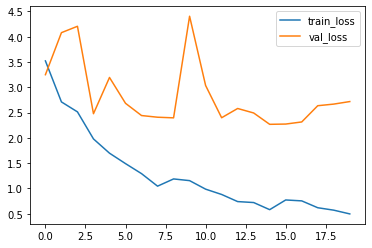

In [69]:
from matplotlib import pyplot as plt
plt.plot(training_loss, label='train_loss')
plt.plot(validation_loss,label='val_loss')
plt.legend()
plt.show

In [ ]:
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 6.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                         num_epochs=25)

(736,)


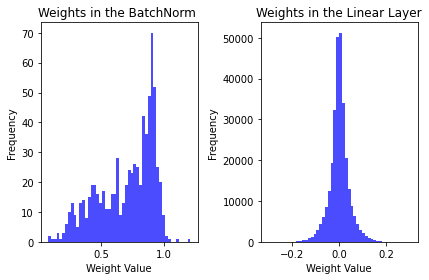

In [71]:
layer1 = Model.classifier[0]
weights1 = layer1.weight.data.cpu().numpy()
print(weights1.shape)
plt.subplot(1,2,1)
plt.hist(weights1.flatten(), bins=50, alpha=0.7, color='b')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Weights in the BatchNorm ')

Linear = Model.classifier[3]
weights2 = Linear.weight.data.cpu().numpy()
plt.subplot(1,2,2)
plt.hist(weights2.flatten(), bins=50, alpha=0.7, color='b')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Weights in the Linear Layer')

plt.tight_layout()
plt.show()

In [72]:
Model.load_state_dict(torch.load('best_Model.pt'))
Model.eval()

VGGIN(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [73]:
testing_loss = []

In [74]:
test_loss = 0.0
test_correct = 0
test_samples = 0
with torch.no_grad():
    
    for i,(images,labels) in tqdm(enumerate(test_loader)):
        
        images = images.to(device).float()
        labels = labels.to(device).long()
        
        output = Model(images)
        
        loss = criterion(output,labels.squeeze())
        test_loss += loss.item()
#         print(f'output = {output}')
#         print(f'loss={loss} and  cummulative loss = {test_loss}')
#         print(output)
        if((i+1)%10 ==0):
#             print(test_loss)
            print(f'the test loss aftet {i+1}/{len(test_loader)} is {test_loss/(i+1)}')
 
        index = torch.argmax(output,1)

        test_correct += (index==labels.squeeze()).sum().item()
        test_samples += labels.size(0)
            
    testing_loss.append(test_loss/(i+1))
    test_acc = 100*n_correct/n_samples
    print(f'Accuracy of the testing data is {test_acc}%')

0it [00:00, ?it/s]

the test loss aftet 10/98 is 3.480872792005539
the test loss aftet 20/98 is 2.4399059042334557
the test loss aftet 30/98 is 2.623214741105039
the test loss aftet 40/98 is 2.8842730473679694
the test loss aftet 50/98 is 2.7662432471904324
the test loss aftet 60/98 is 2.521752489440405
the test loss aftet 70/98 is 2.338207897925973
the test loss aftet 80/98 is 2.197762179150209
the test loss aftet 90/98 is 2.075394849114033
Accuracy of the testing data is 91.25964010282776%


In [70]:
torch.save(model_ft, 'bcancer_model_460p_30epoch-0.987acc.h5')

NameError: name 'model_ft' is not defined

In [ ]:
model_ft=torch.load('bcancer_model_30epoch-0.9699acc.h5')

In [4]:
 def test_model(model ,device, test_loader):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))

In [5]:
def get_confusion_matrix(actuals, predictions):  # create confusion matrix for each class with scikit-learn library
        matplotlib.rcdefaults()
        print('Confusion matrix:/n',confusion_matrix(actuals, predictions))
        cf_matrix=confusion_matrix(actuals, predictions)
        sns.heatmap(cf_matrix, annot=True,fmt='g', cmap='Blues')

In [6]:
models={'resnet18':'PATH HERE'}

for name,model in models.items():
    print('\n'+name+'\n-----------------')  
    model_ft=torch.load(model)
    get_metric.test_model(model_ft,device,dataloaders['val'])
    get_metric.get_roc_curves(model_ft, device,  dataloaders['val'])


resnet18
-----------------


FileNotFoundError: [Errno 2] No such file or directory: 'PATH HERE'